# Part 4: Choose your own adventure! (7 Points; Optional for Extra Credit)

Instruction:  
Please also make sure to structure your notebooks as if you were conducting this as a clean and nicely presented data analysis report. Do not include our prompts/problem statements in the final report notebooks.

### The analysis I chose is "Word frequency over time - does the frequency of certain words change over time".

In this section, we explore how the usage frequency of important words changes over time in State of the Union (SOTU) speeches.
We analyze the lemmatized tokens from earlier parts of the project (Part 1–2).  

You can freely change the target words to see how results differ.

## Basic Imports

In [1]:
import pandas as pd
import spacy
from collections import Counter
import matplotlib.pyplot as plt

## Load Dataset

In [2]:
sou = pd.read_csv("data/SOTU.csv")

sou.head()

,President,Year,Text,Word Count
0,Joseph R. Biden,2024.0,"\n[Before speaking, the President presented hi...",8003
1,Joseph R. Biden,2023.0,\nThe President. Mr. Speaker——\n[At this point...,8978
2,Joseph R. Biden,2022.0,"\nThe President. Thank you all very, very much...",7539
3,Joseph R. Biden,2021.0,\nThe President. Thank you. Thank you. Thank y...,7734
4,Donald J. Trump,2020.0,\nThe President. Thank you very much. Thank yo...,6169


## Preprocessing (Tokenization + Lemmatization)

We will use the same preprocessing steps as before (part 1 + part 2):
- SpaCy for tokenization & lemmatization  
- Remove stopwords, punctuation, spaces  
- Keep only alphabetic tokens  
- Convert to lowercase  


In [3]:
nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):
    doc = nlp(text)
    return [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct and not token.is_space and token.lemma_.isalpha() and len(token.lemma_) > 2]

In [17]:
processed_docs = sou["Text"].apply(preprocess_text)

sou["lemmas"] = processed_docs
sou.head()

,President,Year,Text,Word Count,lemmas,total_tokens
0,Joseph R. Biden,2024.0,"\n[Before speaking, the President presented hi...",8003,"[speak, president, present, prepared, remark, ...",3860
1,Joseph R. Biden,2023.0,\nThe President. Mr. Speaker——\n[At this point...,8978,"[president, speaker, point, president, turn, f...",4148
2,Joseph R. Biden,2022.0,"\nThe President. Thank you all very, very much...",7539,"[president, thank, thank, thank, madam, speake...",3557
3,Joseph R. Biden,2021.0,\nThe President. Thank you. Thank you. Thank y...,7734,"[president, thank, thank, thank, good, mitch, ...",3472
4,Donald J. Trump,2020.0,\nThe President. Thank you very much. Thank yo...,6169,"[president, thank, thank, thank, madam, speake...",3095


## Frequencies of target words for each year of SOTU speeches

In [49]:
target_words = ["economy", "job", "inflation"]

year_word_counts = {w: [] for w in target_words}
years_seen = []

for year, lemmas in zip(sou["Year"], sou["lemmas"]):
    counts = Counter(lemmas)
    years_seen.append(year)
    for w in target_words:
        year_word_counts[w].append(counts[w])

freq_df = pd.DataFrame({"Year": years_seen})
for w in target_words:
    freq_df[w] = year_word_counts[w]

freq_df = freq_df.groupby("Year")[target_words].sum().reset_index().sort_values("Year")

freq_df.head()

,Year,economy,job,inflation
0,1790.0,4,0,0
1,1791.0,0,0,0
2,1792.0,0,0,0
3,1793.0,1,0,0
4,1794.0,1,0,0


## Raw Word Count Over Time

We first visualize the raw counts of each word per year. This helps reveal historical patterns in how often these concepts are mentioned.

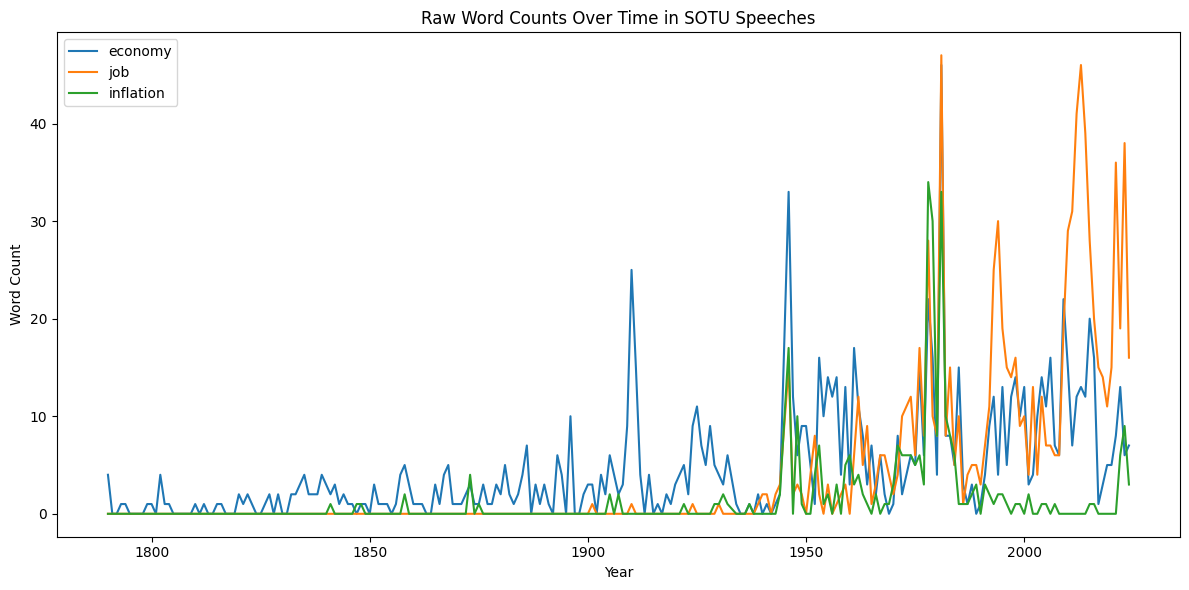

In [50]:
plt.figure(figsize=(12,6))

for w in target_words:
    plt.plot(freq_df["Year"], freq_df[w], label=w)

plt.title("Raw Word Counts Over Time in SOTU Speeches")
plt.xlabel("Year")
plt.ylabel("Word Count")
plt.legend()
plt.tight_layout()

plt.savefig("outputs/P04_figure_1.png")
plt.show()

## Normalized Frequency (Per Token)

Raw word counts can be misleading because the length of State of the Union speeches may vary across time. To control for this, we will compute the proportion of each word relative to the total number of tokens spoken in that year.  

This normalization allows us to compare the relative importance of each word across different time periods, independent of speech length.

In [51]:
sou["total_tokens"] = sou["lemmas"].apply(len)

tokens_per_year = sou.groupby("Year")["total_tokens"].sum().rename("total_tokens_year")

norm_df = freq_df.set_index("Year").join(tokens_per_year, how="left")

for w in target_words:
    norm_df[w + "_rate"] = norm_df[w] / norm_df["total_tokens_year"]
    
norm_df.head()

,economy,job,inflation,total_tokens_year,economy_rate,job_rate,inflation_rate
Year,,,,,,,
1790.0,4,0,0,1872,0.002137,0.0,0.0
1791.0,0,0,0,1922,0.000000,0.0,0.0
1792.0,0,0,0,1702,0.000000,0.0,0.0
1793.0,1,0,0,800,0.001250,0.0,0.0
1794.0,1,0,0,1203,0.000831,0.0,0.0


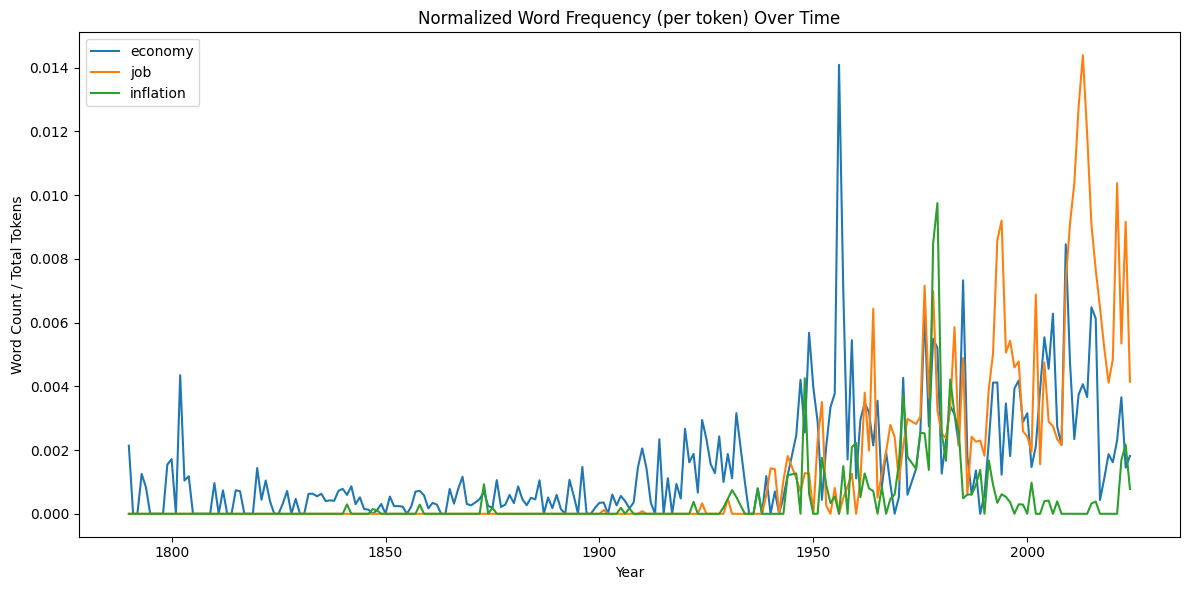

In [52]:
plt.figure(figsize=(12, 6))

for w in target_words:
    col = w + "_rate"
    plt.plot(norm_df.index, norm_df[col], label=w)

plt.title("Normalized Word Frequency (per token) Over Time")
plt.xlabel("Year")
plt.ylabel("Word Count / Total Tokens")
plt.legend()
plt.tight_layout()

plt.savefig("outputs/P04_figure_2.png")
plt.show()

## Interpretation

The words “economy,” “job,” and “inflation” show clear historical patterns in State of the Union speeches.  
"Economy" remained relatively uncommon before the 1900s but increased sharply during the Great Depression and continued rising throughout the modern era as economic policy became a central presidential theme. The term "job" appears more frequently after World War II and spikes noticeably in the 1970s–1980s, reflecting periods of unemployment concerns and labor-market instability. In contrast, "inflation" shows almost no usage for most of U.S. history but exhibits a dramatic peak during the late 1970s and early 1980s, corresponding to the high-inflation crisis of that period. Both raw and normalized frequencies show the same trends, indicating that these patterns reflect real shifts in political focus rather than differences in speech length.

Out of different words I've tried out, these words showed highest correlation to the history.